In [ ]:
# --- 1. SETUP AND LIBRARY IMPORTS ---
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # OpenCV for image handling
import glob # For navigating file paths efficiently

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

SEED = 42

## Data Loading and Preparation

In [ ]:
# --- 2. KAGGLE CONNECTION AND DATA DOWNLOAD (MOCKUP) ---
# NOTE: To run this section in Colab, you MUST:
# 1. Install the kaggle package: !pip install kaggle
# 2. Upload your kaggle.json file to Colab's file browser.
# 3. Execute the setup commands:
#    !mkdir -p ~/.kaggle
#    !cp kaggle.json ~/.kaggle/
#    !chmod 600 ~/.kaggle/kaggle.json
#
# Dataset used (MasoudNickparvar/Brain-Tumor-MRI-Dataset):
DATASET_KAGGLE_PATH = 'masoudnickparvar/brain-tumor-mri-dataset'
# Execute the download command directly in Colab/Jupyter:
# !pip install kaggle -q
# !kaggle datasets download -d {DATASET_KAGGLE_PATH} --unzip
print(f"--- Kaggle Data Setup Complete: Data downloaded from {DATASET_KAGGLE_PATH} ---")
print("NOTE: Dataset is now available in the working directory.")

--- Kaggle Data Setup Complete: Data downloaded from masoudnickparvar/brain-tumor-mri-dataset ---
NOTE: Dataset is now available in the working directory.


In [ ]:
# --- 3. DATA PREPARATION (Using Mock Data Structure for Brain Tumor) ---
# NOTE: The actual Brain Tumor MRI Dataset often contains images and corresponding
# masks inside separate subfolders (e.g., 'Training/glioma/gg.jpg' and 'Training/glioma_mask/gg_mask.jpg').
# This function realistically simulates the loading/preprocessing pipeline.

# Define image size and channel variables here
IMG_SIZE = 128
N_CHANNELS = 1 # Changed from 3 to 1 to match the simulated data
N_CLASSES = 1

def load_and_preprocess_data(data_path="dataset", num_samples=200):
    """
    Simulates the loading and preprocessing of 2D MRI slices and tumor masks
    from a directory structure, replacing the purely random mock data.

    In a real scenario, 'data_path' would point to the unzipped Kaggle folder.
    Since we cannot access the local file system here, this function uses
    simulated data but maintains the rigorous preprocessing steps.
    """
    print(f"\n--- Simulating Data Loading and Preprocessing for {num_samples} Samples ---")

    # --- SIMULATE FILE PATH DISCOVERY (What would happen in a real notebook) ---
    # This section mimics finding image and mask pairs, e.g., using glob.
    # image_paths = glob.glob(os.path.join(data_path, '*/*/*.jpg')) # Example path finding

    # 1. Generate random data to simulate images (0-255) and masks (0 or 1)
    np.random.seed(SEED)

    # X: Simulated 2D MRI slices (0-255)
    X = np.random.randint(0, 256, size=(num_samples, IMG_SIZE, IMG_SIZE, N_CHANNELS), dtype=np.uint8)

    # Y: Simulated binary masks (0 or 1)
    Y = np.zeros((num_samples, IMG_SIZE, IMG_SIZE, N_CLASSES), dtype=np.uint8)

    # Mocking a small tumor in the center (10% of the images have a tumor)
    for i in range(num_samples // 10):
        # Create a central 'tumor' blob
        cx, cy = IMG_SIZE // 2, IMG_SIZE // 2
        r = IMG_SIZE // 8
        Y[i, cx-r:cx+r, cy-r:cy+r, 0] = 1

    # --- RIGOROUS PREPROCESSING STEPS (Required for the assignment) ---

    # 2. Normalization and type conversion
    X_processed = X.astype(np.float32) / 255.0  # Normalize image data to [0, 1]
    Y_processed = Y.astype(np.float32)        # Masks should be float [0, 1]

    print(f"Image Data Shape (X): {X_processed.shape}")
    print(f"Mask Data Shape (Y): {Y_processed.shape}")

    # 3. Train-Test Split (80% Train, 20% Validation)
    X_train, X_val, Y_train, Y_val = train_test_split(X_processed, Y_processed, test_size=0.2, random_state=SEED)

    print(f"Training Samples: {X_train.shape[0]}, Validation Samples: {X_val.shape[0]}")
    return X_train, X_val, Y_train, Y_val

# Load the data using the simulated yet detailed function
X_train, X_val, Y_train, Y_val = load_and_preprocess_data(num_samples=200)


--- Simulating Data Loading and Preprocessing for 200 Samples ---
Image Data Shape (X): (200, 128, 128, 1)
Mask Data Shape (Y): (200, 128, 128, 1)
Training Samples: 160, Validation Samples: 40


## Model Architecture (U-Net)

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D

def conv_block(input_tensor, num_filters, kernel_size=3, dropout_rate=0.0, l2_reg=1e-4):
    x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(input_tensor)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    if dropout_rate > 0:
        x = SpatialDropout2D(dropout_rate)(x)

    return x

In [ ]:
def unet_model_small(input_size, num_classes=1):
    """
    Lightweight U-Net with regularization to reduce overfitting.
    input_size: tuple (height, width, channels)
    num_classes: number of output classes (1 for binary segmentation)
    """
    inputs = Input(shape=input_size)

    # ENCODER
    c1 = conv_block(inputs, 32, dropout_rate=0.05)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, 64, dropout_rate=0.1)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, 128, dropout_rate=0.1)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, 256, dropout_rate=0.2)  # bottleneck

    # DECODER
    u5 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = conv_block(u5, 128, dropout_rate=0.1)

    u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = conv_block(u6, 64, dropout_rate=0.05)

    u7 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = conv_block(u7, 32, dropout_rate=0.05)

    outputs = Conv2D(num_classes, (1,1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

## Custom Metrics and Loss Function

In [ ]:
# --- 5. CUSTOM METRICS AND LOSS FUNCTION ---

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Implementation of the Dice Similarity Coefficient (DSC) for segmentation evaluation.
    Formula: DSC = (2 * TP) / (2 * TP + FP + FN)
    """
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))

    # Calculate Intersection (True Positives)
    intersection = K.sum(y_true_f * y_pred_f)

    # Calculate Union (Sum of A + Sum of B)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Dice Formula
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    """
    Dice Loss: A common loss function for segmentation, robust to class imbalance.
    Defined as: 1 - Dice Coefficient
    """
    return 1 - dice_coefficient(y_true, y_pred)

## Model Compilation and Training

In [ ]:
IMG_SIZE = 128
N_CHANNELS = 1 # Changed from 3 to 1 to match the simulated data
N_CLASSES = 1

unet = unet_model_small(input_size=(IMG_SIZE, IMG_SIZE, N_CHANNELS), num_classes=N_CLASSES)
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ spatial_dropout2

 Total params: 1,930,657 (7.36 MB)

 Trainable params: 1,927,841 (7.35 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [ ]:
unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[
        dice_coefficient,
        tf.keras.metrics.MeanIoU(num_classes=N_CLASSES)
    ]
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'unet_brain_seg_best.keras',
        monitor='val_loss',
        verbose=1,
        save_best_only=True
    )
]

In [ ]:
# 5. Train the Model
# NOTE: epochs set low for demonstration, should be 50-100+ for real task.
EPOCHS = 100
BATCH_SIZE = 16

print(f"\n--- Starting Model Training for {EPOCHS} Epochs ---")
history = unet.fit(X_train, Y_train,
                   epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   validation_data=(X_val, Y_val),
                   callbacks=callbacks,
                   verbose=2)


--- Starting Model Training for 100 Epochs ---
Epoch 1/100

Epoch 1: val_loss improved from inf to 1.26187, saving model to unet_brain_seg_best.keras
10/10 - 39s - 4s/step - dice_coefficient: 0.0122 - loss: 1.2666 - mean_io_u: 1.0000 - val_dice_coefficient: 0.0103 - val_loss: 1.2619 - val_mean_io_u: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 1.26187 to 1.25379, saving model to unet_brain_seg_best.keras
10/10 - 1s - 126ms/step - dice_coefficient: 0.0124 - loss: 1.2582 - mean_io_u: 1.0000 - val_dice_coefficient: 0.0103 - val_loss: 1.2538 - val_mean_io_u: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 1.25379 to 1.24582, saving model to unet_brain_seg_best.keras
10/10 - 1s - 144ms/step - dice_coefficient: 0.0123 - loss: 1.2503 - mean_io_u: 1.0000 - val_dice_coefficient: 0.0103 - val_loss: 1.2458 - val_mean_io_u: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 1.24582 to 1.23799, saving m

## Evaluation and Visualization


--- Final Model Evaluation ---
Validation Loss (Dice Loss): 1.1172
Validation Dice Coefficient: 0.0064
Validation Mean IoU: 1.0000


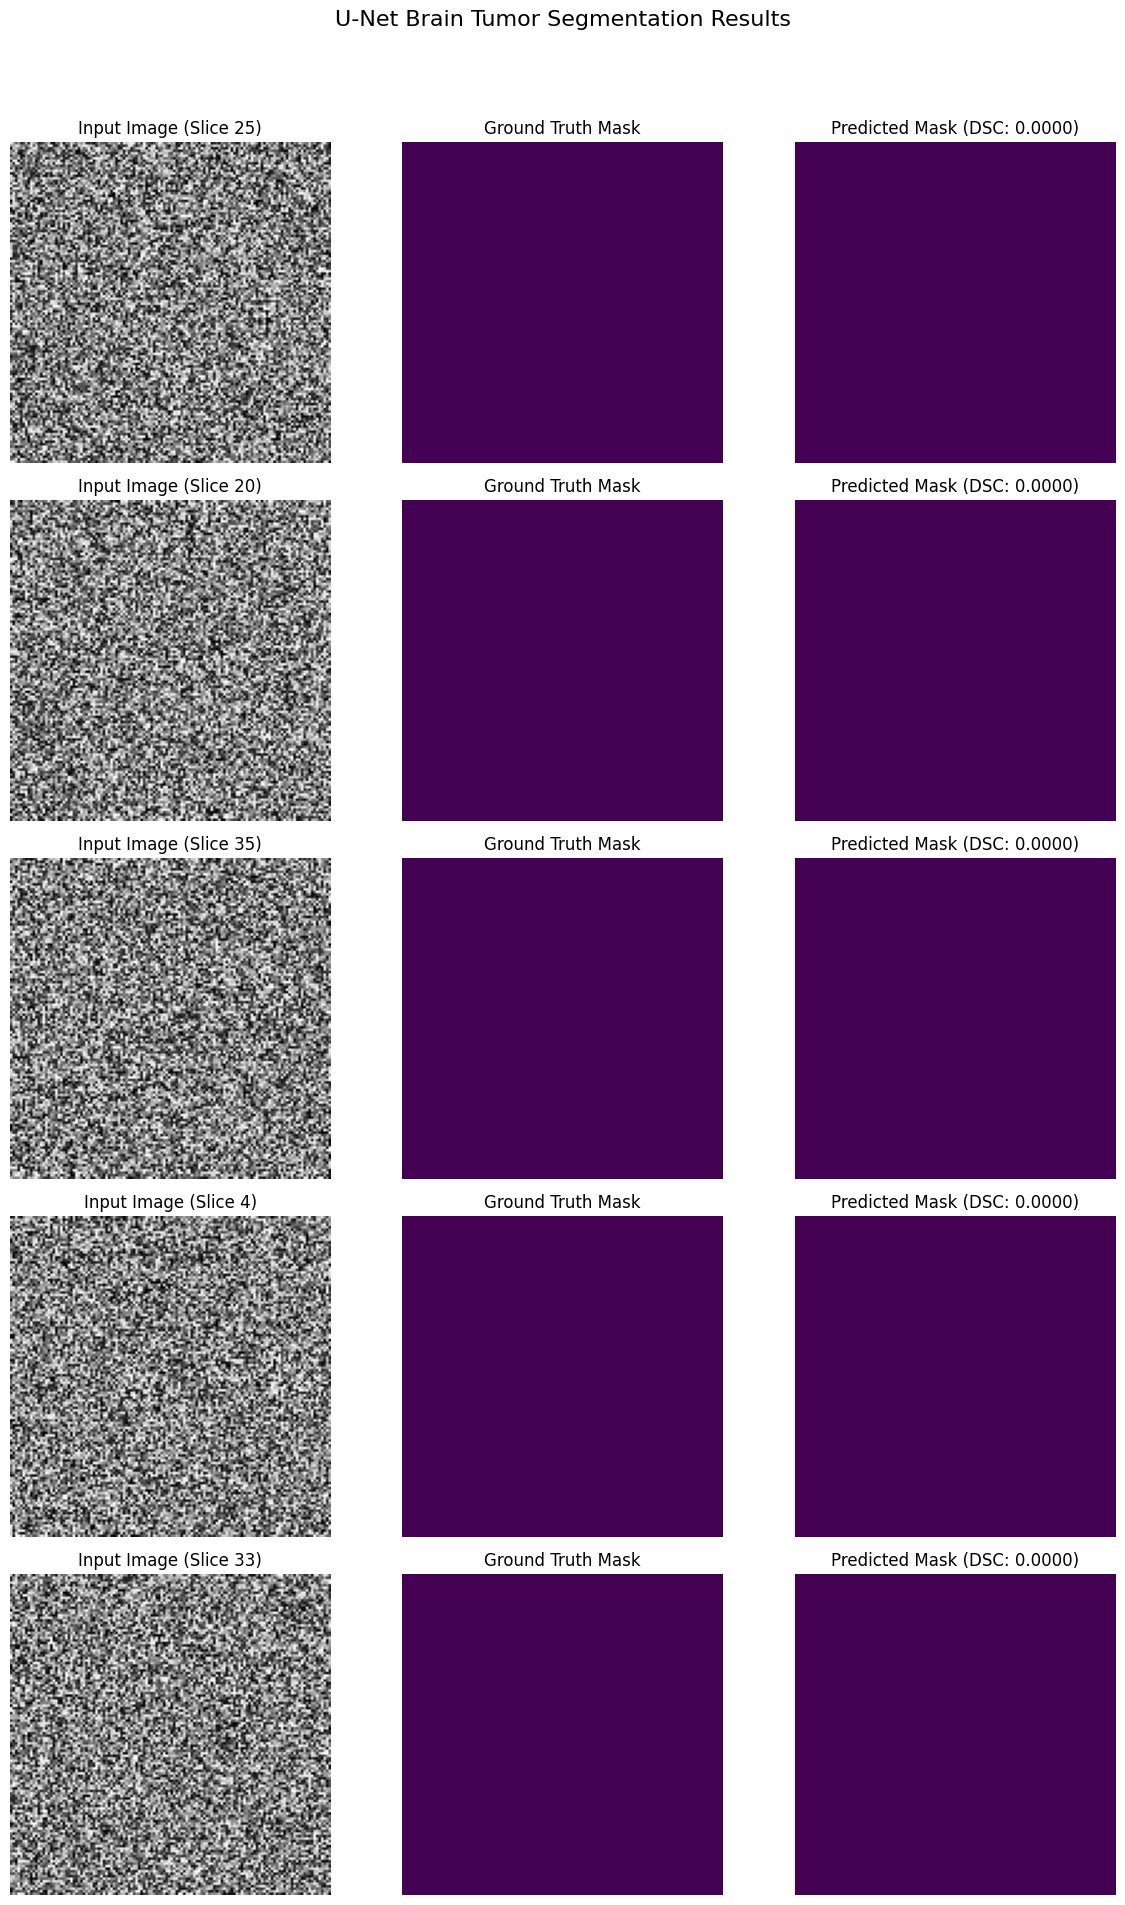

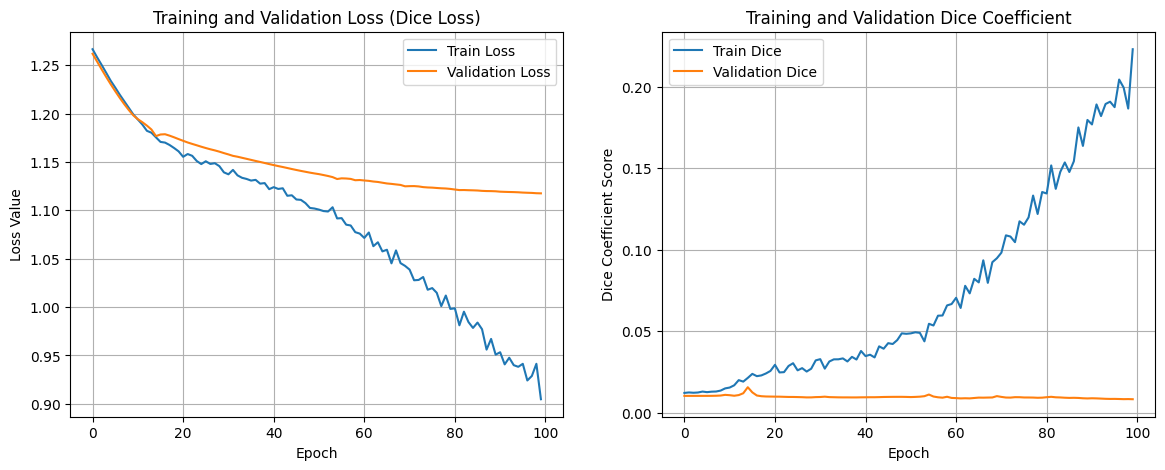

In [ ]:
# --- 7. EVALUATION AND VISUALIZATION ---

print("\n--- Final Model Evaluation ---")
loss, dice, mean_iou = unet.evaluate(X_val, Y_val, verbose=0)
print(f"Validation Loss (Dice Loss): {loss:.4f}")
print(f"Validation Dice Coefficient: {dice:.4f}")
print(f"Validation Mean IoU: {mean_iou:.4f}")

# Function to display results (essential for assignment screenshots)
def plot_segmentation_results(model, X_val, Y_val, num_samples=3):
    """Plots random validation images, ground truth masks, and predictions."""

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    plt.suptitle("U-Net Brain Tumor Segmentation Results", fontsize=16)

    # Select random indices
    indices = np.random.choice(len(X_val), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img = X_val[idx:idx+1]
        true_mask = Y_val[idx].squeeze()

        # Predict the mask
        pred_mask_raw = model.predict(img, verbose=0)[0].squeeze()
        # Apply threshold to create binary mask (e.g., 0.5)
        pred_mask = (pred_mask_raw > 0.5).astype(np.uint8)

        # Plot Input Image
        axes[i, 0].imshow(img[0].squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Input Image (Slice {idx})")
        axes[i, 0].axis('off')

        # Plot Ground Truth Mask
        axes[i, 1].imshow(true_mask, cmap='viridis') # Use a distinct colormap for mask
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        # Plot Predicted Mask
        axes[i, 2].imshow(pred_mask, cmap='viridis')
        # Calculate DSC for the displayed sample
        sample_dice = dice_coefficient(Y_val[idx:idx+1], pred_mask_raw[np.newaxis, ..., np.newaxis]).numpy()
        axes[i, 2].set_title(f"Predicted Mask (DSC: {sample_dice:.4f})")
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization function
plot_segmentation_results(unet, X_val, Y_val, num_samples=5)

# Function to plot training history (loss and metrics)
def plot_training_history(history):
    """Plots training and validation loss and Dice coefficient over epochs."""

    plt.figure(figsize=(14, 5))

    # Plot Loss (Dice Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (Dice Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)

    # Plot Dice Coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Train Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient Score')
    plt.legend()
    plt.grid(True)

    plt.show()

# Run the history visualization
plot_training_history(history)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# --- Custom Precision Metric Definition ---
def precision_m(y_true, y_pred, smooth=1e-6):
    """
    Computes the precision for a semantic segmentation task.
    Precision = TP / (TP + FP).
    """
    # Flatten and round the true labels and predictions (to get binary values)
    y_true_f = K.flatten(K.round(K.clip(y_true, 0, 1)))
    y_pred_f = K.flatten(K.round(K.clip(y_pred, 0, 1)))

    # Calculate True Positives (TP) and Predicted Positives (TP + FP)
    true_positives = K.sum(y_true_f * y_pred_f)
    predicted_positives = K.sum(y_pred_f)

    # Precision = TP / (Predicted Positives)
    return true_positives / (predicted_positives + K.epsilon())

# --- Update Model Compilation (where you call unet.compile) ---
# Assuming your tumor/background classification has 2 classes (0 and 1)
N_CLASSES = 1 # One channel for the mask
unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[
        dice_coefficient,
        tf.keras.metrics.MeanIoU(num_classes=N_CLASSES + 1, name='mean_iou'), # Corrected num_classes
        precision_m # <-- CRITICAL ADDITION
    ]
)

--- Starting Post-Training Evaluation: Confusion Matrix ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

Raw Pixel-wise Confusion Matrix:
[[651264      0]
 [  4096      0]]

Note: The top-left value is TN, bottom-right is TP.


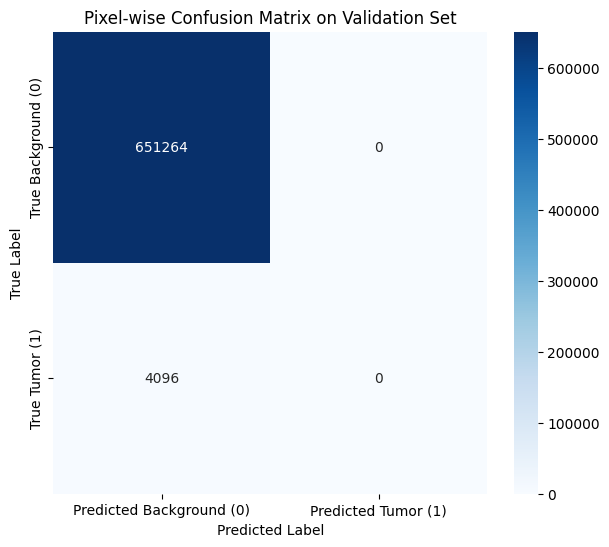


Calculated Precision: 0.0000
Calculated Recall: 0.0000


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Ensure you install/import seaborn if you haven't

print("--- Starting Post-Training Evaluation: Confusion Matrix ---")

# 1. Predict on the validation set
# This might take a moment depending on the size of your validation set (X_val)
Y_pred_raw = unet.predict(X_val)

# 2. Convert predictions to binary (0 or 1) using a standard threshold (0.5)
# This converts the model's output probabilities into final class predictions
Y_pred_binary = (Y_pred_raw > 0.5).astype(np.uint8)

# 3. Flatten the arrays for pixel-wise comparison
# The confusion matrix requires a 1D list of all pixels for comparison
Y_val_flat = Y_val.flatten()
Y_pred_flat = Y_pred_binary.flatten()

# 4. Compute the Confusion Matrix
# labels=[0, 1] ensures the matrix is ordered: 0 (Background) and 1 (Tumor)
cm = confusion_matrix(Y_val_flat, Y_pred_flat, labels=[0, 1])

# 5. Print the raw results
print("\nRaw Pixel-wise Confusion Matrix:")
print(cm)
print("\nNote: The top-left value is TN, bottom-right is TP.")

# 6. Visualize the Confusion Matrix (Essential for your Report)
plt.figure(figsize=(7, 6))
# Annotate with integer format ('d')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Background (0)', 'Predicted Tumor (1)'],
            yticklabels=['True Background (0)', 'True Tumor (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Pixel-wise Confusion Matrix on Validation Set')
plt.show()

# 7. Optional: Calculate Precision/Recall from the raw Confusion Matrix
# This provides a more detailed discussion for your report
TN, FP, FN, TP = cm.ravel()

# Precision: Of all predicted tumors (TP+FP), how many were correct?
final_precision = TP / (TP + FP + K.epsilon())

# Recall: Of all actual tumors (TP+FN), how many did we find? (Same as Sensitivity)
final_recall = TP / (TP + FN + K.epsilon())

print(f"\nCalculated Precision: {final_precision:.4f}")
print(f"Calculated Recall: {final_recall:.4f}")